In [1]:
%pip install river pandas==2.2.2 scipy==1.13.1 numpy==1.26.1


[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install matplotlib yfinance matplotlib yfinance numpy scikit-learn river scikit-optimize pysqlite3


[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from river import metrics

# Importando as classes refatoradas
from utils.SeriesProcessor import SeriesProcessor
from utils.ModelTrainer import ModelTrainer
from utils.DriftEvaluator import DriftEvaluator
from utils.Visualizer import Visualizer
from utils.Optimizer import Optimizer

# Importando as classes existentes de otimização
from classes.otimizador.OtimizadorBayesiano import OtimizadorBayesiano

# 1. Importar os modelos e detectores de drift

In [4]:
# Importando detectores de drift
from classes.detectores.ADWINDetector import ADWINDetector
from classes.detectores.DDMDetector import DDMDetector
from classes.detectores.EDDMDetector import EDDMDetector
from classes.detectores.FHDDMDetector import FHDDMDetector
from classes.detectores.HDDM_ADetector import HDDM_ADetector
from classes.detectores.PageHinkleyDetector import PageHinkleyDetector
from classes.detectores.HDDM_WDetector import HDDM_WDetector
#from classes.detectores.KSWINDetector import KSWINDetector

# Importando modelos offline
from classes.modelosOffline.LinearRegressionModelo import LinearRegressionModelo
from classes.modelosOffline.KneighborsRegressorModelo import KNeighborsRegressorModelo
from classes.modelosOffline.LassoRegressionModelo import LassoRegressionModelo
from classes.modelosOffline.RidgeRegressionModelo import RidgeRegressionModelo
from classes.modelosOffline.SVRModelo import SVRModelo
from classes.modelosOffline.RandomForestModelo import RandomForestModelo
from classes.modelosOffline.MLPRegressorModelo import MLPRegressorModelo

# Importando modelos online
from classes.modelosOnline.BayesianLinearRegressionModelo import BayesianLinearRegressionModelo
from classes.modelosOnline.HoeffdingTreeRegressorModelo import HoeffdingTreeRegressorModelo
from classes.modelosOnline.KNNRegressorOnlineModelo import KNNRegressorOnlineModelo
from classes.modelosOnline.LinearRegressionOnlineModelo import LinearRegressionOnlineModelo

# 2. Baixar e preparar os dados

In [5]:
# Lista de séries temporais disponíveis
series = [
    "AAPL",
    "B3SA3.SA",
    "^IXIC",
    "^DJI",
    "^GSPC",
    "^BVSP",
    "USDBRL=X"
]

In [6]:
# Definindo parâmetros para processamento
tamanho_batch = 50
lags = 5
serie_escolhida = series[-2]
print(f"Processando série: {serie_escolhida}")

# Baixando os dados da ação
serie_temporal = SeriesProcessor.baixar_dados(serie_escolhida)

# Normalizando a série temporal
serie_temporal = SeriesProcessor.normalizar_serie(serie_temporal)
print(f"Shape da série após normalização: {serie_temporal.shape}")

# Gerando janelas temporais
X, Y = SeriesProcessor.criar_janela_temporal(serie_temporal, lags)
print(f"Shape dos dados de entrada: {X.shape}")
print(f"Shape dos dados de saída: {Y.shape}")

Processando série: ^BVSP
YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Shape da série após normalização: (1244, 1)
Shape dos dados de entrada: (1239, 5)
Shape dos dados de saída: (1239, 1)


# 3. Otimização de Hiperparâmetros

In [7]:
# Lista de modelos a otimizar (classes)
modelos_offline = [
    LinearRegressionModelo,
    KNeighborsRegressorModelo,
    LassoRegressionModelo,
    #MLPRegressorModelo,  # Comentado por ser mais lento
    RandomForestModelo,
    RidgeRegressionModelo,
    SVRModelo
]

modelos_online = [
    BayesianLinearRegressionModelo,
    HoeffdingTreeRegressorModelo,
    KNNRegressorOnlineModelo,
    LinearRegressionOnlineModelo
]

# Inicializar o otimizador
optimizer = OtimizadorBayesiano(n_iter=20, cv=3, random_state=42)

# Otimizando todos os modelos
modelos_otimizados, parametros_otimizados = Optimizer.otimizar_todos_modelos(
    X, Y, tamanho_batch, lags=lags, optimizer=optimizer,
    modelos_offline=modelos_offline,
    modelos_online=modelos_online
)

# Salvar parâmetros otimizados para uso futuro
import json
with open('parametros_otimizados.json', 'w') as f:
    # Converter valores não serializáveis para strings
    params_serializaveis = {}
    for modelo, params in parametros_otimizados.items():
        params_serializaveis[modelo] = {k: str(v) for k, v in params.items()}
    json.dump(params_serializaveis, f, indent=4)

print("Parâmetros otimizados salvos em 'parametros_otimizados.json'")


Otimizando LinearRegressionModelo...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [True, False, True] before, using random point [False, True, False]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [True, False, False] before, using random point [True, True, False]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [True, False, True] before, using random point [True, False, False]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [True, False, False] before, using random point [True, True, True]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [True, False, True] before, using random point [False, True, False]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [True, False, True] before, using random point [True, True, False]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [True, True, False] before, using random point [False, False, False]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [False, False, False] before, using random point [True, False, True]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [True, True, False] before, using random point [True, True, False]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits

Otimizando KNeighborsRegressorModelo...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds

/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.898e-01, tolerance: 5.658e-04
  model = cd_fast.enet_coordinate_descent(
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.540e+00, tolerance: 9.778e-04
  model = cd_fast.enet_coordinate_descent(
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits

Otimizando RandomForestModelo...
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector 


Otimizando RidgeRegressionModelo...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for

/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-v

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-v

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-v

Espaço de parâmetros não definido para BayesianLinearRegressionModelo
Espaço de parâmetros não definido para HoeffdingTreeRegressorModelo
Espaço de parâmetros não definido para KNNRegressorOnlineModelo
Espaço de parâmetros não definido para LinearRegressionOnlineModelo
Parâmetros otimizados salvos em 'parametros_otimizados.json'


# 4. Executando Avaliação Prequential com Detecção de Drift

In [8]:
# Detector de drift a ser usado
detector_escolhido = ADWINDetector

# Executando prequential com os modelos otimizados
resultados = {}
deteccoes_por_modelo = {}

for nome_modelo, modelo in modelos_otimizados.items():
    print(f"\nExecutando prequential para {nome_modelo}...")
    predicoes, deteccoes = DriftEvaluator.prequential_batch(X, Y, tamanho_batch, modelo_classe=type(modelo), detector_classe=detector_escolhido)
    resultados[nome_modelo] = predicoes
    deteccoes_por_modelo[nome_modelo] = deteccoes  # Armazena as detecções

    print(f"Número de detecções para {nome_modelo}: {len(deteccoes)}")


Executando prequential para LinearRegressionModelo...
Modelo utilizado: LinearRegressionModelo()
Detector utilizado: <classes.detectores.ADWINDetector.ADWINDetector object at 0x7a1d10ad9a30>
MAE Modelo Batch: [0.09391964]
Desvio Padrão dos Erros: 0.07558623181312384
Número de detecções para LinearRegressionModelo: 0

Executando prequential para KNeighborsRegressorModelo...

Mudança detectada no índice 208, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 207 até 257.

Mudança detectada no índice 512, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 511 até 561.

Mudança detectada no índice 848, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 847 até 897.
Modelo utilizado: <classes.modelosOffline.KneighborsRegressorModelo.KNeighborsRegressorModelo object at 0x7a1d1300f9e0>
Detector utilizado: <classes.detectores.A

/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Mudança detectada no índice 208, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 207 até 257.


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Mudança detectada no índice 512, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 511 até 561.


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Mudança detectada no índice 848, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 847 até 897.


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Modelo utilizado: <classes.modelosOffline.RandomForestModelo.RandomForestModelo object at 0x7a1d1300f9e0>
Detector utilizado: <classes.detectores.ADWINDetector.ADWINDetector object at 0x7a1d10121c10>
MAE Modelo Batch: 0.47910196772386154
Desvio Padrão dos Erros: 0.5260691033912223
Número de detecções para RandomForestModelo: 3

Executando prequential para RidgeRegressionModelo...
Modelo utilizado: <classes.modelosOffline.RidgeRegressionModelo.RidgeRegressionModelo object at 0x7a1d10121c10>
Detector utilizado: <classes.detectores.ADWINDetector.ADWINDetector object at 0x7a1d101233e0>
MAE Modelo Batch: 0.10102114668979092
Desvio Padrão dos Erros: 0.07752502782560361
Número de detecções para RidgeRegressionModelo: 0

Executando prequential para SVRModelo...


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-v


Mudança detectada no índice 176, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 175 até 225.

Mudança detectada no índice 448, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 447 até 497.

Mudança detectada no índice 656, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 655 até 705.

Mudança detectada no índice 832, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 831 até 881.

Mudança detectada no índice 1040, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 1039 até 1089.
Modelo utilizado: <classes.modelosOffline.SVRModelo.SVRModelo object at 0x7a1d10122b10>
Detector utilizado: <classes.detectores.ADWINDetector.ADWINDetector object at 0x7a1d10122180>
MAE Modelo Batch: 0.653604761617371
Desvio Pa

/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Nenhum drift detectado para LinearRegressionModelo.

Drift detectado para KNeighborsRegressorModelo nos índices: [208, 512, 848]

Nenhum drift detectado para LassoRegressionModelo.

Drift detectado para RandomForestModelo nos índices: [208, 512, 848]

Nenhum drift detectado para RidgeRegressionModelo.

Drift detectado para SVRModelo nos índices: [176, 448, 656, 832, 1040]


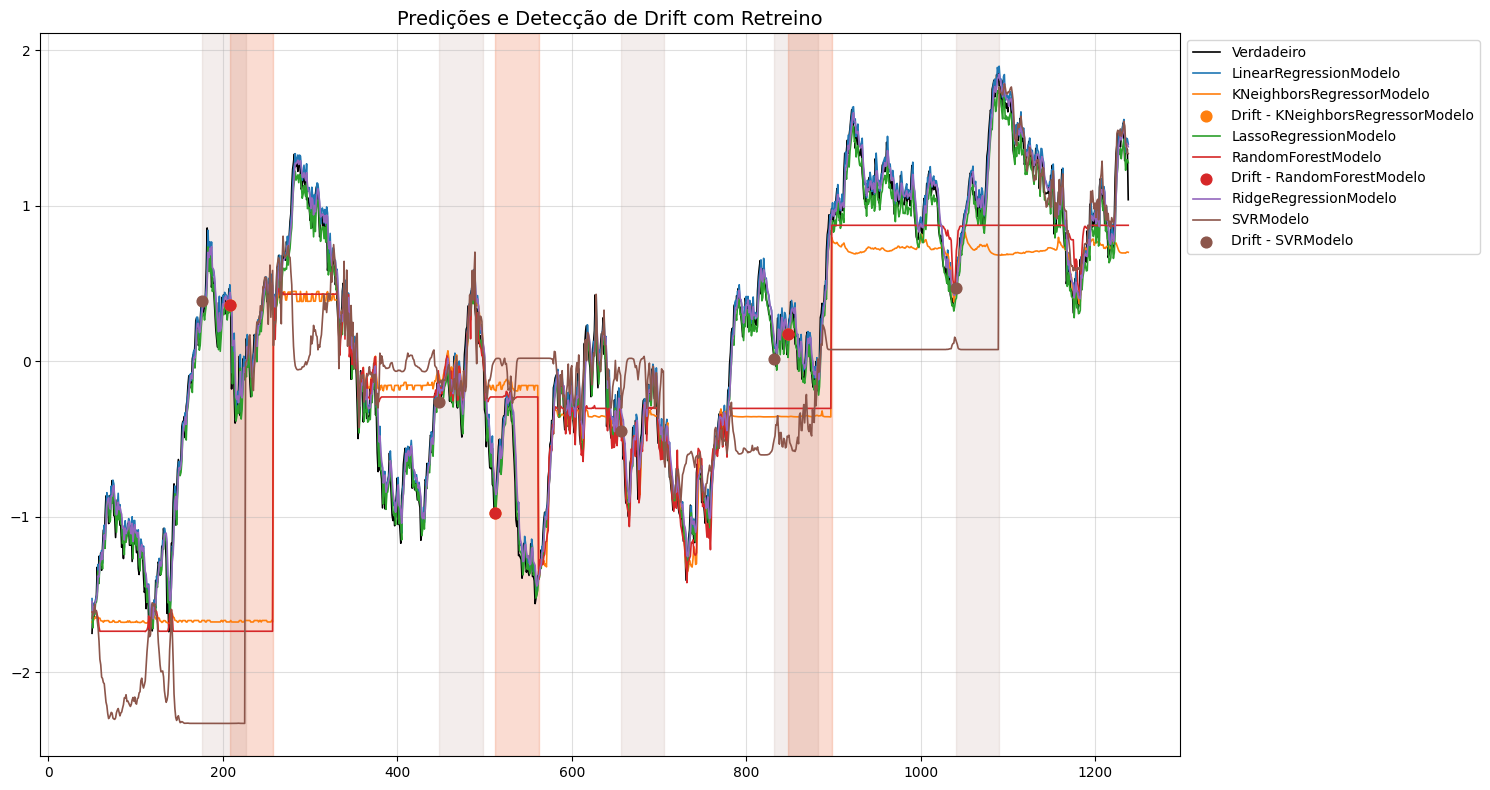

In [9]:
# Plotando os resultados
Visualizer.plotar_resultados_multi(Y,
                  list(resultados.values()),
                  list(resultados.keys()),
                  deteccoes_por_modelo,
                  tamanho_batch)

# 5. Comparação de Detectores de Drift

In [10]:
# Selecionando um modelo para testar com diferentes detectores
modelo_escolhido = LinearRegressionModelo
print(f"Modelo selecionado para testes comparativos: {modelo_escolhido.__name__}")

# Lista de detectores a testar
detectores = [
    ADWINDetector,
    DDMDetector,
    EDDMDetector,
    FHDDMDetector,
    HDDM_ADetector,
    PageHinkleyDetector
]

resultados_detectores = {}
deteccoes_detectores = {}

for detector in detectores:
    nome_detector = detector.__name__
    print(f"\nTestando {nome_detector}...")
    predicoes, deteccoes = DriftEvaluator.prequential_batch(X, Y, tamanho_batch, modelo_classe=modelo_escolhido, detector_classe=detector)
    resultados_detectores[nome_detector] = predicoes
    deteccoes_detectores[nome_detector] = deteccoes
    print(f"Número de detecções para {nome_detector}: {len(deteccoes)}")

Modelo selecionado para testes comparativos: LinearRegressionModelo

Testando ADWINDetector...
Modelo utilizado: LinearRegressionModelo()
Detector utilizado: <classes.detectores.ADWINDetector.ADWINDetector object at 0x7a1d10120800>
MAE Modelo Batch: [0.09391964]
Desvio Padrão dos Erros: 0.07558623181312384
Número de detecções para ADWINDetector: 0

Testando DDMDetector...
Modelo utilizado: LinearRegressionModelo()
Detector utilizado: <classes.detectores.DDMDetector.DDMDetector object at 0x7a1d101233e0>
MAE Modelo Batch: [0.09391964]
Desvio Padrão dos Erros: 0.07558623181312384
Número de detecções para DDMDetector: 0

Testando EDDMDetector...
Modelo utilizado: LinearRegressionModelo()
Detector utilizado: <classes.detectores.EDDMDetector.EDDMDetector object at 0x7a1d10123b60>
MAE Modelo Batch: [0.09391964]
Desvio Padrão dos Erros: 0.07558623181312384
Número de detecções para EDDMDetector: 0

Testando FHDDMDetector...
Modelo utilizado: LinearRegressionModelo()
Detector utilizado: <classes


Nenhum drift detectado para ADWINDetector.

Nenhum drift detectado para DDMDetector.

Nenhum drift detectado para EDDMDetector.

Nenhum drift detectado para FHDDMDetector.

Nenhum drift detectado para HDDM_ADetector.

Nenhum drift detectado para PageHinkleyDetector.


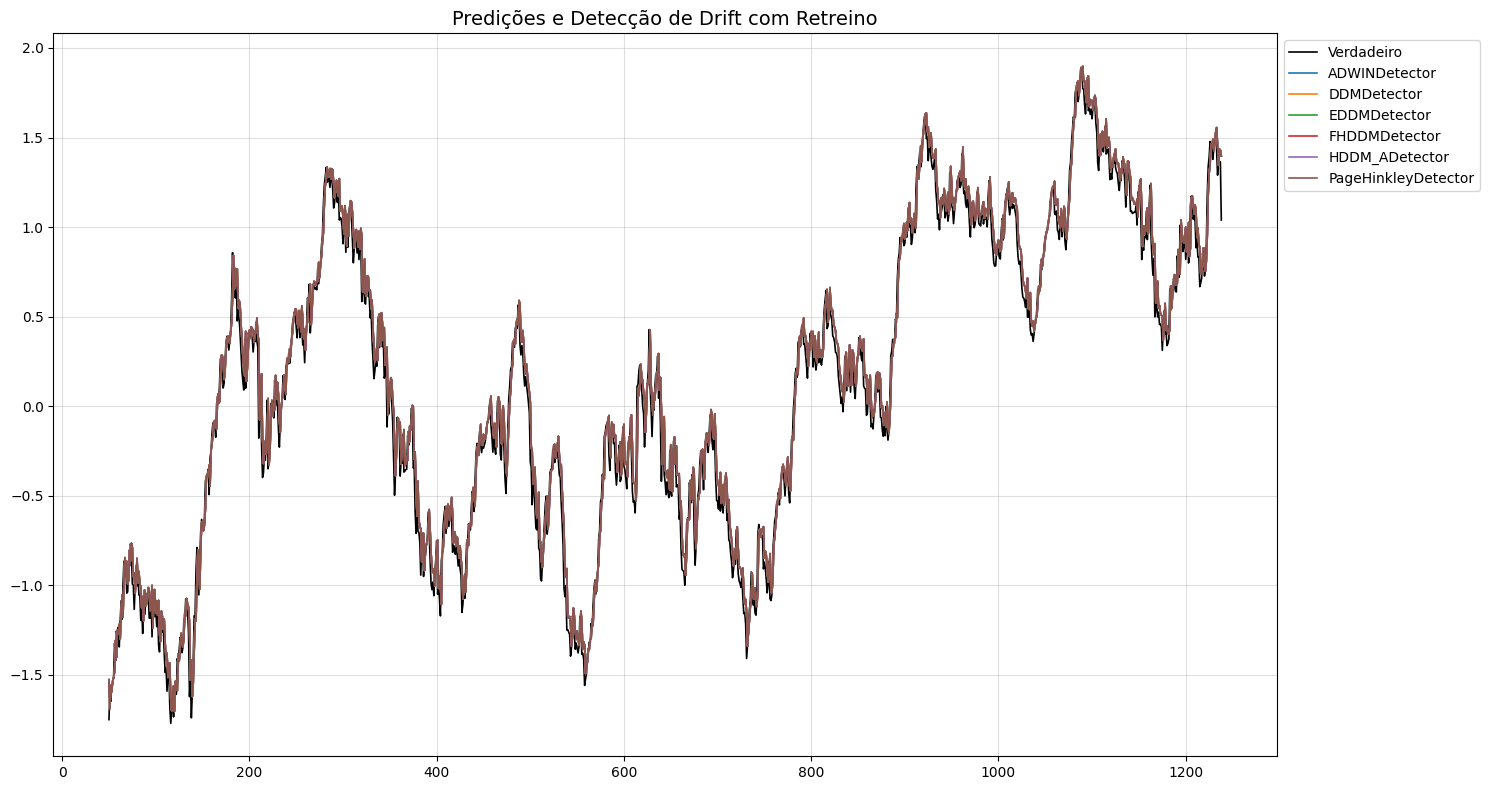

In [11]:
# Plotando comparação de detectores
Visualizer.plotar_resultados_multi(Y,
                  list(resultados_detectores.values()),
                  list(resultados_detectores.keys()),
                  deteccoes_detectores,
                  tamanho_batch)